In [1]:
#!pip install transformers==4.12.0
#!pip install tensorflow==2.4.0
#!pip install datasets
#!pip install wandb
#!pip install langdetect

In [2]:
first_run = False

In [7]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
#from google.colab import drive
from langdetect import detect
import matplotlib.dates as md

%load_ext autoreload
%autoreload 2

#drive.mount('/content/drive/')
#%cd '/content/drive/My Drive/eu_commission'

### Read in the data

In [317]:
fs = glob.glob('data/*/*')
fields = ['text', 'lang']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
processed_tws = []
for f in fs:
    tws = json.load(open(f))['data']
    for i in range(len(tws)):
        item = {k: tws[i][k] for k in fields}
        item.update({k: tws[i]['public_metrics'][k] for k in metrics})
        item.update({'created_at': tws[i]['created_at'][:10]})
        tws[i] = item
    processed_tws += tws

In [318]:
df = pd.DataFrame(processed_tws)
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)

### Tweet volume

In [319]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (50,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_volume(language='en', freqs='D', plot_smooth_only=False, roll_window=7):
    top_dict = {}
    for freq in [freqs]:
        fig, ax = plt.subplots(figsize=figsizes[freq])
        if df['created_at'].dtype != 'datetime64':
            df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
        if language=='all':
            grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()      
        elif language=='en':
            grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()
        else:
            new_df = df.copy()
            new_df['is_other'] = np.where((new_df['lang']=='en') & (new_df['lang_detected']=='en'), 0, 1)
            counts = new_df.groupby(grouper).count().reset_index()[['created_at','text']].rename({'text': 'count'}, axis=1)
            by_lang = new_df.groupby([grouper,'is_other']).count().reset_index() 
            grouped = pd.merge(by_lang, counts, how='outer')
            grouped['text'] = np.where(grouped['count'] != 0, grouped['text'] / grouped['count'], 0)
            grouped = grouped[grouped['is_other']==1]
            grouped = grouped.fillna(0)
        top_dict[freq_dict[freq]] = grouped.sort_values(by='text', ascending=False).head(n=5)[['created_at', 'text']].to_records(index=False)
        grouped['smoothed'] = grouped['text'].rolling(roll_window).mean()
        # Plot 
        if not plot_smooth_only:
            sns.lineplot(data=grouped, x='created_at', y='text', 
                         alpha=.2, 
                         label='per day')
        sns.lineplot(data=grouped, x='created_at', y='smoothed', 
                     label=f'smoothed avg - {roll_window}d', 
                     color=sns.color_palette()[0])
        if language in ['all', 'en']:
            plt.ylabel(f'Tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Tweet volume {language.upper()}')
        else:
            plt.ylabel(f'Proportion tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Proportion tweets not in English')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),120), color='black')
        ax.xaxis.set_major_locator(md.MonthLocator())
        ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        if language == 'en':
            plt.savefig(f'figures/tweet_volume_EN.pdf')
        else:
            plt.savefig(f'figures/tweet_volume_others.pdf')
        plt.show()
    return top_dict

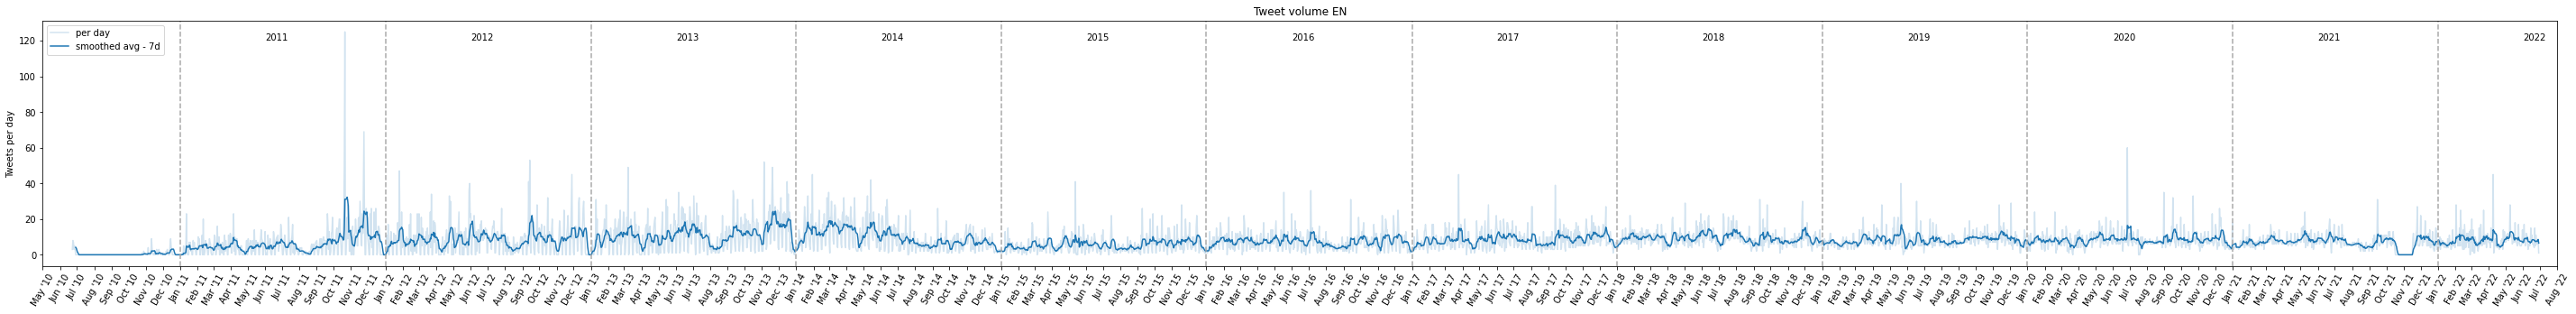

In [320]:
top_dict = plot_volume(roll_window=7)

In [321]:
print(df[df.created_at == np.datetime64(top_dict['day'][1][0])].text.tolist())
print(top_dict['day'][1][0])

['Air transport: #EC requests Austria, Germany, Italy and Luxembourg to comply with rules on airport charges  http://t.co/sVQ7iwfQ', 'Maritime safety:#EC requests #Italy to comply with new safety rules for passenger ships http://t.co/hMqNwrO7', 'Rail: #EC refers #Germany to Court of Justice over railway safety http://t.co/0Nfo9eAp', '#EC asks the #United Kingdom to pay due amounts of customs duties to #EU budget  http://t.co/qsjObEPR', 'Free movement of goods: #EC requests #Greece to facilitate the selling of "bake off" products  http://t.co/qH6GSk8m', 'Free movement of goods: #EC requests #Netherlands to comply with EU rules on firearms  http://t.co/3KCimGLY', "Working time: #EC requests #Belgium to end compulsory postponement of workers' annual leave http://t.co/U9GlQkPC", 'Free movement of workers: #EC requests #Italy to end discrimination in recruiting university professors  http://t.co/PFJGDfLI', 'Social Security: #EC requests #Spain to end refusal of European Health Insurance Car

Some of the peaks with highest volumes are related to live tweeting of #EUMFF negotiations, automated posting re: to activity on other websites (Storify), and other. 
Worth keeping in mind that tweet volume can be a major confounder with this data.

### Additional preprocessing
- flag retweets and tweets starting with mentions;
- strip links;
- not removing emojis, hashtags and mentions, for now - but could remove depending on which model we end up using;
- assign some tweet to a "pretraining" dataset

Re: this latter. Let's leave out a small dataset for pretraining of our language models. We pick a random set of tweets (if that does not show good results, we could consider balanced sampling over time).

In [322]:
def language_detection(s):
    try:
        return detect(s)
    except:
        return 'unk'

In [323]:
if first_run is True:
    
    # Preprocessing
    df['is_retweet'] = np.where(df['text'].str.startswith('RT'), 1, 0)
    df['is_mention'] = np.where(df['text'].str.startswith('@'), 1, 0)
    df['text'] = df['text'].str.replace(r'http.*', '', regex=True)
    df = df[df['text'].str.len() > 0]
    df['lang_detected'] = df['text'].apply(language_detection)
    df[df['lang']!=df['lang_detected']]
    
    # Pretraining splits
    import random
    random.seed(42)
    train_size = 3000
    val_size = 500
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * (df.shape[0] - train_size - val_size)
    random.shuffle(train_test)
    df['pretraining_splits'] = train_test
    
    # Save
    df.to_json('processed/all_tweets.jsonl', lines=True, orient='records')

Breakdown of number of tweets per language

In [3]:
df = pd.read_json('processed/all_tweets.jsonl', lines=True, orient='records')
print(df.groupby('lang')['text'].count().reset_index().sort_values(by='text', ascending=False).rename({'text': 'count'}, axis=1))

   lang  count
7    en  32446
12   fr    828
5    de    207
8    es    155
29  und    122
17   it     81
24   ro     69
28   uk     47
22   pl     45
20   nl     37
23   pt     36
1    ca     33
6    el     29
4    da     28
9    et     23
11   fi     22
2    cs     21
26   sv     19
0    bg     16
15   in     12
19   lv     10
18   lt     10
25   sl     10
14   hu      9
27   tl      5
3    cy      4
13   ht      2
10   eu      2
21   no      1
16   is      1


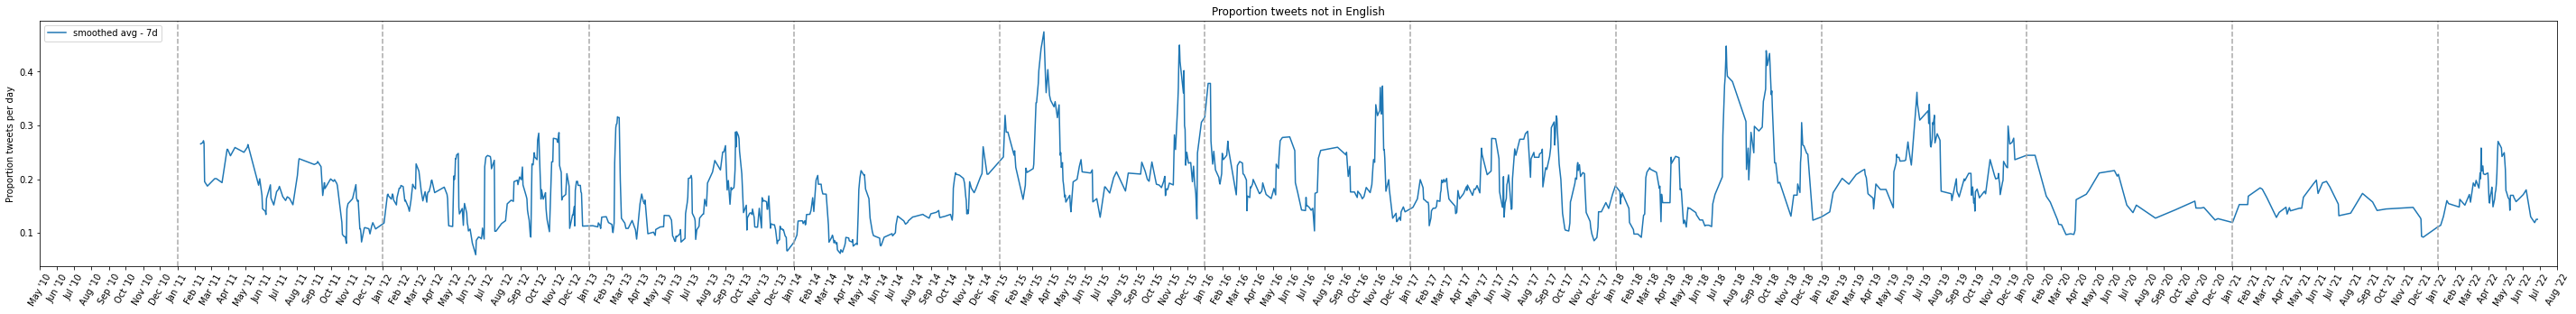

In [325]:
top_dict_other = plot_volume(language='other', freqs='D', plot_smooth_only=True, roll_window=7)

Removing tweets not in English, it's mostly translations of English tweets. We know that Twitter's automatic language detection is not great, so double-checking with langdetect and only including tweets tagged as English by both the default tagger and langdetect.

In [4]:
df = df[(df['lang']=='en') & (df['lang_detected']=='en')]

Great, now let's fine tune some language models on these tweets for better performance (see pretrain script)

### Pretraining performance analysis

In [14]:
performances = pd.read_json('logs/pretraining/performances.jsonl', lines=True, orient='records')
performances['learning_rate'] = performances['name'].str.split('_').str[1].str.split('-').str[1]
performances['batch_size'] = performances['name'].str.split('_').str[4].str.split('-').str[1]
performances['warmup'] = performances['name'].str.split('_').str[5].str.split('-').str[1]
performances['chunk_size'] = performances['name'].str.split('_').str[2].str.split('-').str[1]

Let's first visualize the impact of learning rates.

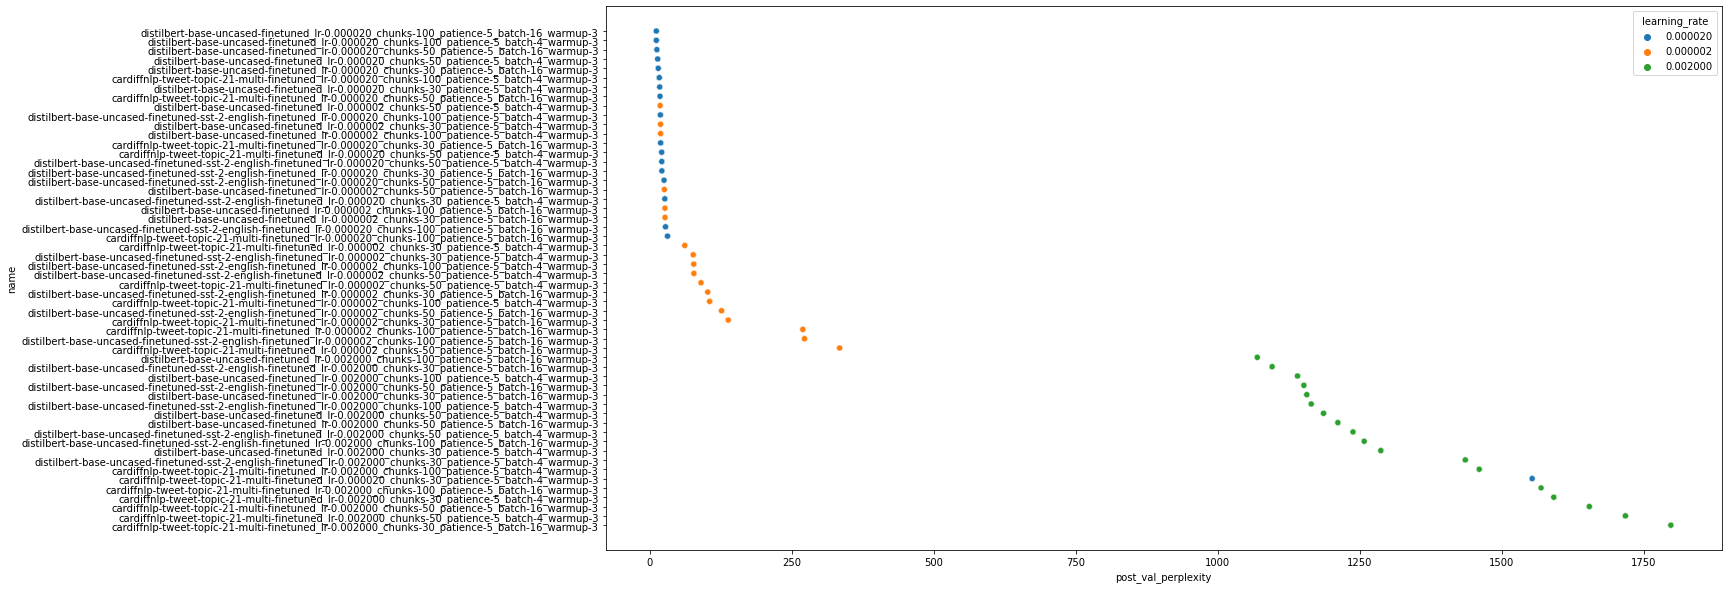

In [15]:
plt.subplots(figsize=(20,10))
sns.scatterplot(data=performances.sort_values(by='post_val_perplexity'), y='name', x='post_val_perplexity', hue='learning_rate')
plt.show()

Best learning rate seems to be univocally 2e-5. Now on batch size, and it seems like we can stick to 4.

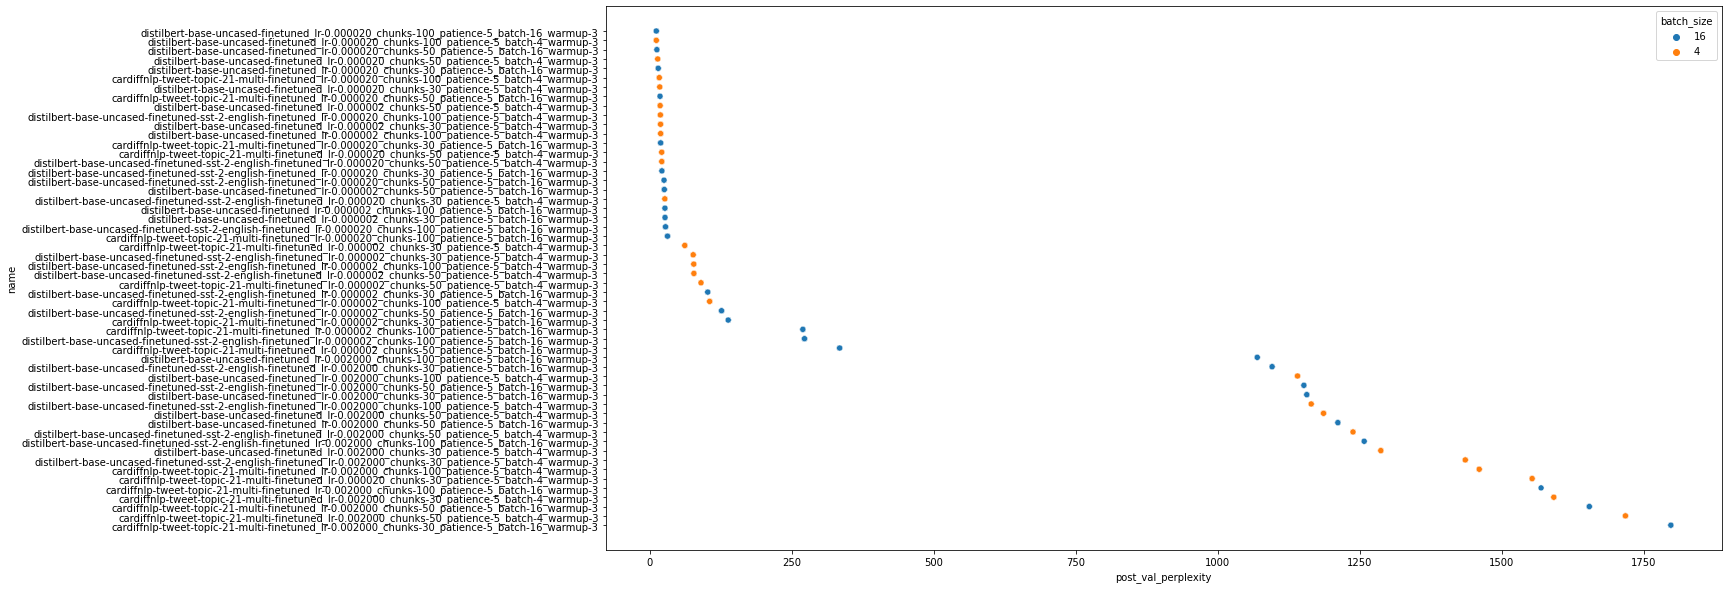

In [16]:
plt.subplots(figsize=(20,10))
sns.scatterplot(data=performances.sort_values(by='post_val_perplexity'), y='name', x='post_val_perplexity', hue='batch_size')
plt.show()

And finally, chunk size. No terribly clear pattern here, so let's just go with 100.

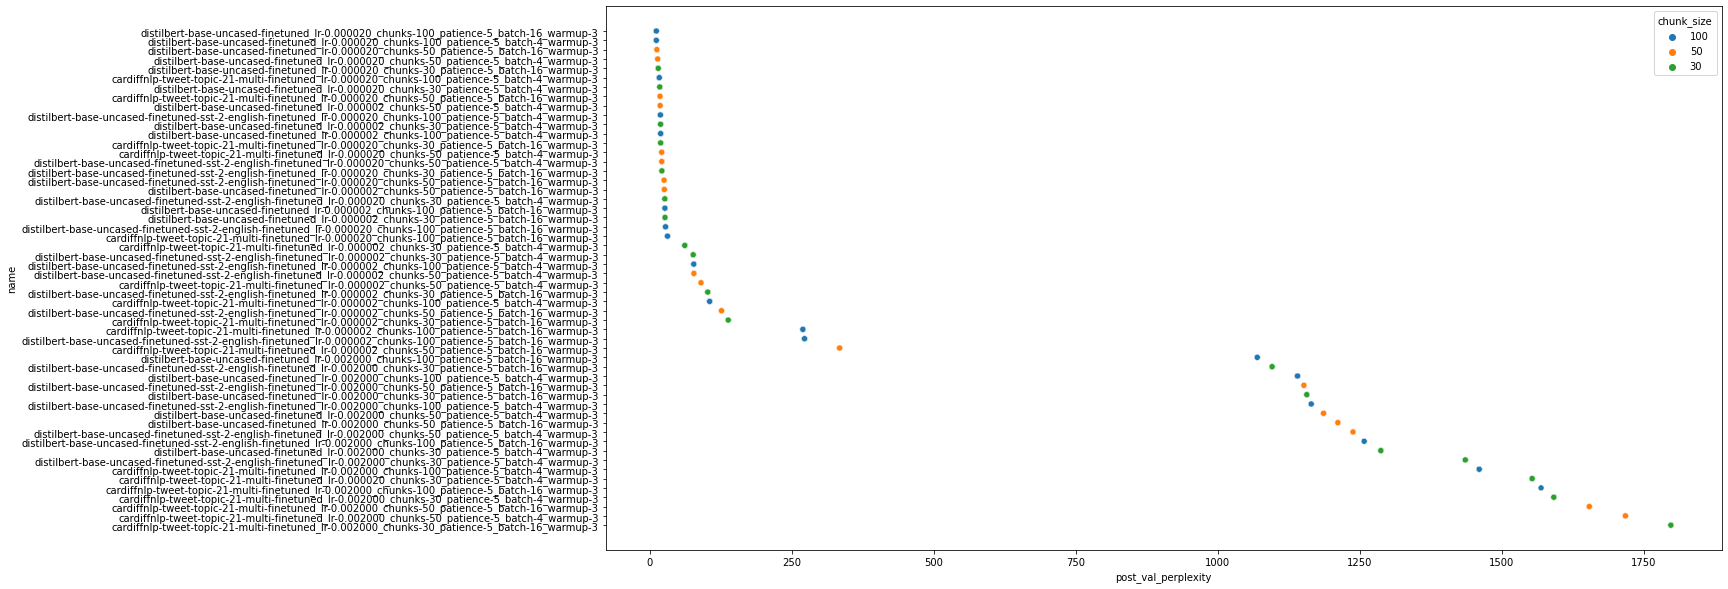

In [17]:
plt.subplots(figsize=(20,10))
sns.scatterplot(data=performances.sort_values(by='post_val_perplexity'), y='name', x='post_val_perplexity', hue='chunk_size')
plt.show()

Removing other batch sizes and learning rates to different folder (or deleting).

### Topic modeling
Let's move on to modeling the topic of the tweets. We'll try to compare different modeling strategies, and both pretrained and fine-tuned models.
Then, we'll try to get an idea of what the evolution of topics has been over time. 
Let's start from comparing model metrics for multiple models, and parameter optimization configs.

#### Generate data

In [6]:
first_contextualized_run = False

In [11]:
if first_contextualized_run is True:
    topic_df = df[df['pretraining_splits']=='test'].sample(frac=1).reset_index()
    
    # Train test split
    import random
    random.seed(42)
    train_size = int(topic_df.shape[0] * .7)
    val_size = int(topic_df.shape[0] * .1)
    test_size = topic_df.shape[0] - train_size - val_size
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * test_size
    random.shuffle(train_test)
    
    # Pretrained
    topic_df['topic_split'] = train_test 
    topic_df.to_json('processed/pre_topic_tweets.jsonl', lines=True, orient='records')

Training through `run_topics.py`

In [9]:
topic_perf = pd.read_json('logs/topic/performances.jsonl', orient='records', lines=True)

In [139]:
topic_perf['vocab'] = topic_perf['name'].str.split('vocab-').str[1].str.split('_').str[0]
topic_perf['bow'] = topic_perf['name'].str.split('bow-').str[1].str.split('_').str[0]
topic_perf['esize'] = topic_perf['name'].str.split('esize-').str[1].str.split('_').str[0]
topic_perf['components'] = np.where(topic_perf['name'].str.split('_').str[0].str.endswith(r'finetuned'), 
                                    topic_perf['name'].str.split('_').str[8].str.lstrip(r'comp\-'),
                                    topic_perf['name'].str.split('_').str[3].str.lstrip(r'comp\-')).astype(float)
topic_perf['lr_topic'] = np.where(topic_perf['name'].str.split('_').str[0].str.endswith(r'finetuned'), 
                                  topic_perf['name'].str.split('_').str[11].str.lstrip(r'lr\-'),
                                  topic_perf['name'].str.split('_').str[6].str.lstrip(r'lr\-')).astype(float)
topic_perf['batch_topic'] = np.where(topic_perf['name'].str.split('_').str[0].str.endswith(r'finetuned'), 
                                     topic_perf['name'].str.split('_').str[10].str.lstrip(r'batch\-'),
                                     topic_perf['name'].str.split('_').str[5].str.lstrip(r'batch\-')).astype(int)
topic_perf['lr_pretraining'] = np.where(topic_perf['name'].str.split('_').str[0].str.endswith(r'finetuned'), 
                                        topic_perf['name'].str.split('_').str[1].str.lstrip(r'lr\-'),
                                        0).astype(float)
topic_perf['model_id'] = topic_perf['name'].str.split('_').str[0].str.rstrip(r'\-finetuned') 
topic_perf['unique_id'] = topic_perf['model_id'] + '_comp' + topic_perf['components'].astype(str) + \
                          '_vocab' + topic_perf['vocab'].astype(str) + '_' + \
                          '_lrt' + topic_perf['lr_topic'].astype(str) + '_batch' + topic_perf['batch_topic'].astype(str) + \
                          '_lrp' + topic_perf['lr_pretraining'].astype(str) 

Let's check parameters. Definitely better with 2e-2 for learning rate.

To do:
- Run batch = 64
- Try default 2e-3 learning rate
- Top models have < 100 components
- Vocabulary does not necessarily matter

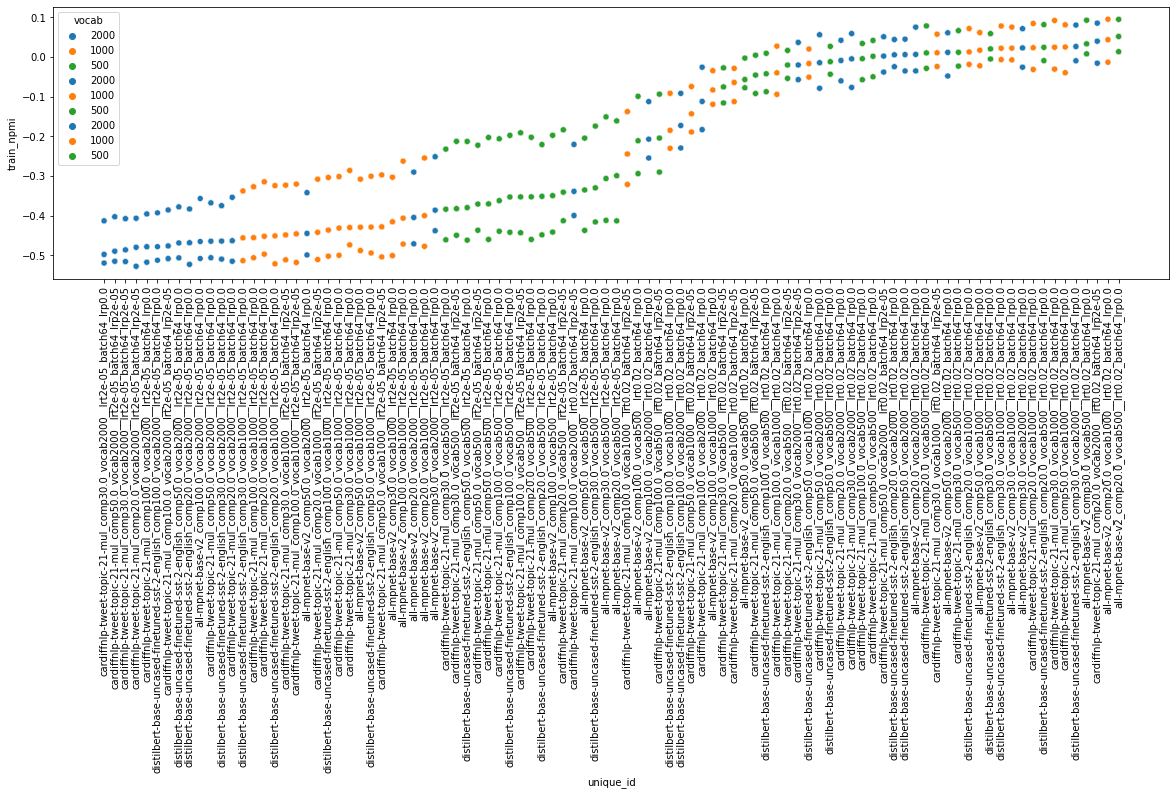

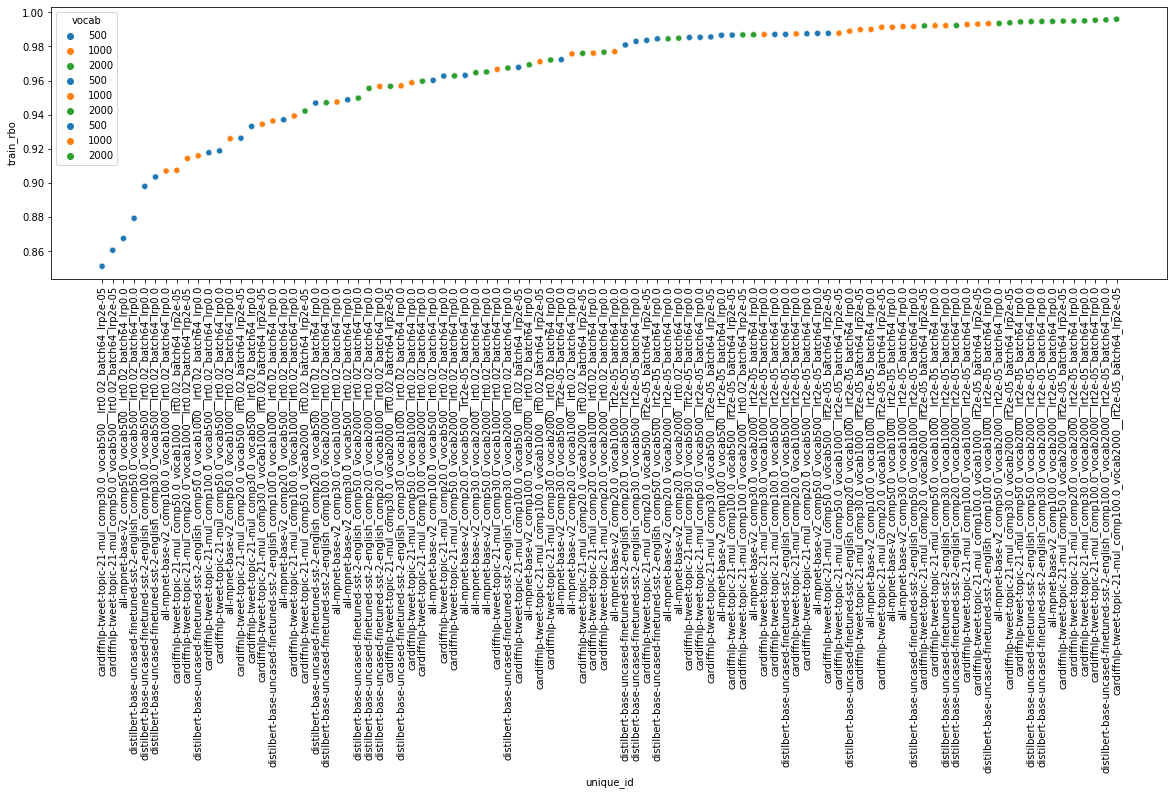

In [152]:
for metric in ['npmi', 'rbo']:
    plt.subplots(figsize=(20,5))
    cp_perf = topic_perf.sort_values(by=f'test_{metric}')
    for split in ['train', 'val', 'test']:
        sns.scatterplot(data=cp_perf, x='unique_id', y=f'{split}_{metric}', hue='vocab')
        plt.xticks(rotation=90)
    plt.show()

#### Compare metrics for trained models

In [2]:
# Read the overall performances
# Inspect the models
# Predicted

### Next steps

- Fit other models

Analysis
- Engagement as a function of topic
- Topics & engagement as a function of emotions of EU Commission tweet
- Collect comments, annotate emotions in comments, plot emotion of reactions as a function of topics
    - Also polarization?

Other:
- Decide whether to include mentions and retweets
- Streamline preprocessing